<a href="https://colab.research.google.com/github/MohuaSinha/EVA4/blob/master/EVA4/S6/EVA4_S6_Solution_4cases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [44]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [47]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

# The model
Let's start with the model we first saw

In [0]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 26, RF=3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 24,RF=5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 22,RF=7

        # TRANSITION BLOCK 1
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        ) # output_size = 22,RF=7

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11,RF=9

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 9,RF=11

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 7,RF=15

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 5,RF=19
        
         
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size =1,RF=21

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        ) # output_size =1,RF=21

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )  # output_size =1,RF=21


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [49]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 20, 22, 22]           1,800
             ReLU-10           [-1, 20, 22, 22]               0
      BatchNorm2d-11           [-1, 20, 22, 22]              40
          Dropout-12           [-1, 20, 22, 22]               0
        MaxPool2d-13           [-1, 20, 11, 11]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses_no_L1_L2 = []
test_losses_no_L1_L2 = []
train_acc_no_L1_L2 = []
test_acc_no_L1_L2 = []

train_losses_L1 = []
test_losses_L1 = []
train_acc_L1 = []
test_acc_L1 = []

train_losses_L2 = []
test_losses_L2 = []
train_acc_L2 = []
test_acc_L2 = []

train_losses_L1_L2 = []
test_losses_L1_L2 = []
train_acc_L1_L2 = []
test_acc_L1_L2 = []

In [0]:

def L1_regularization(model, data, factor=0.00025):
  l1_crit = nn.L1Loss().to(device)
  reg_loss = 0
  for param in model.parameters():
    zero_vector = torch.rand_like(param) * 0
    reg_loss += l1_crit(param, zero_vector)
  return factor * reg_loss  

In [0]:
def train(model, device, train_loader, optimizer, epoch,isL1Regularization, train_acc, train_losses):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if isL1Regularization:
      loss += L1_regularization(model,data,factor=0.00025)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

In [0]:
def test(model, device, test_loader,test_acc, test_losses):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
def plot(test_losses,test_acc,label):
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0].plot(test_losses, label=label)
  axs[0].set_title("Test Loss")
  axs[1].plot(test_acc, label=label)
  axs[1].set_title("Test Accuracy")

In [0]:
def plotall():
  fig, axs = plt.subplots(1,2,figsize=(20,8))
  axs[0].plot(test_losses_no_L1_L2, label='no L1/L2')
  axs[0].plot(test_losses_L1, label=' L1 ')
  axs[0].plot(test_losses_L2, label=' L2 ')
  axs[0].plot(test_losses_L1_L2, label=' L1 & L2 ')
  axs[0].set_title("Test Loss")
  axs[0].legend()
  axs[1].plot(test_acc_no_L1_L2, label='no L1/L2')
  axs[1].plot(test_acc_L1, label=' L1 ')
  axs[1].plot(test_acc_L2, label=' L2 ')
  axs[1].plot(test_acc_L1_L2, label=' L1 & L2 ')
  axs[1].set_title("Test Accuracy")
  axs[1].legend()
  plt.savefig('/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/GRAPHS.png')

# Let's Train and test our model

# **CASE 1: NO L1 OR L2 REGULARIZATION**

In [56]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

# Scenario 1: Used no L1 or L2 regularization here
EPOCHS = 40 
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,False, train_acc_no_L1_L2, train_losses_no_L1_L2)
    test(model, device, test_loader,test_acc_no_L1_L2, test_losses_no_L1_L2)

PATH = '/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/model_no_L1_l2_40epochs.pt'
torch.save(model, PATH)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.13800759613513947 Batch_id=468 Accuracy=90.71: 100%|██████████| 469/469 [00:13<00:00, 34.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0603, Accuracy: 9811/10000 (98.11%)

EPOCH: 1


Loss=0.12976007163524628 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:13<00:00, 43.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9874/10000 (98.74%)

EPOCH: 2


Loss=0.10124685615301132 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:14<00:00, 33.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9908/10000 (99.08%)

EPOCH: 3


Loss=0.04451463744044304 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:14<00:00, 33.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9889/10000 (98.89%)

EPOCH: 4


Loss=0.06826665252447128 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:13<00:00, 34.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9917/10000 (99.17%)

EPOCH: 5


Loss=0.05342743173241615 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:13<00:00, 33.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9923/10000 (99.23%)

EPOCH: 6


Loss=0.1052946224808693 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 33.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.018181463703513145 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:14<00:00, 32.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9929/10000 (99.29%)

EPOCH: 8


Loss=0.004364088177680969 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:13<00:00, 33.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9938/10000 (99.38%)

EPOCH: 9


Loss=0.0358143076300621 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:14<00:00, 32.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9944/10000 (99.44%)

EPOCH: 10


Loss=0.03256940469145775 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 40.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.042308393865823746 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:13<00:00, 34.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.011629268527030945 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 33.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.01998957432806492 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 39.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.02954115718603134 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:14<00:00, 32.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9949/10000 (99.49%)

EPOCH: 15


Loss=0.013693357817828655 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 33.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9946/10000 (99.46%)

EPOCH: 16


Loss=0.009388054721057415 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 34.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9947/10000 (99.47%)

EPOCH: 17


Loss=0.020247826352715492 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 32.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9938/10000 (99.38%)

EPOCH: 18


Loss=0.06500404328107834 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:14<00:00, 33.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9938/10000 (99.38%)

EPOCH: 19


Loss=0.09440788626670837 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:14<00:00, 33.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9951/10000 (99.51%)

EPOCH: 20


Loss=0.015543043613433838 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:14<00:00, 33.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9949/10000 (99.49%)

EPOCH: 21


Loss=0.060314860194921494 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 38.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9943/10000 (99.43%)

EPOCH: 22


Loss=0.003880441188812256 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 33.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9942/10000 (99.42%)

EPOCH: 23


Loss=0.027163684368133545 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 33.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 9948/10000 (99.48%)

EPOCH: 24


Loss=0.008629892952740192 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:14<00:00, 32.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9948/10000 (99.48%)

EPOCH: 25


Loss=0.02100732922554016 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 33.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9950/10000 (99.50%)

EPOCH: 26


Loss=0.013646528124809265 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 32.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0146, Accuracy: 9962/10000 (99.62%)

EPOCH: 27


Loss=0.016203170642256737 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 33.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0142, Accuracy: 9958/10000 (99.58%)

EPOCH: 28


Loss=0.05078558996319771 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 39.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9944/10000 (99.44%)

EPOCH: 29


Loss=0.0027524183969944715 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 33.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9945/10000 (99.45%)

EPOCH: 30


Loss=0.00771998381242156 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 32.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0147, Accuracy: 9953/10000 (99.53%)

EPOCH: 31


Loss=0.00897874403744936 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:13<00:00, 33.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 9950/10000 (99.50%)

EPOCH: 32


Loss=0.008801768533885479 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 38.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0139, Accuracy: 9961/10000 (99.61%)

EPOCH: 33


Loss=0.003813718678429723 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 33.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9947/10000 (99.47%)

EPOCH: 34


Loss=0.011459211818873882 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0136, Accuracy: 9952/10000 (99.52%)

EPOCH: 35


Loss=0.003830547211691737 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 33.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0133, Accuracy: 9953/10000 (99.53%)

EPOCH: 36


Loss=0.01953810453414917 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 39.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9947/10000 (99.47%)

EPOCH: 37


Loss=0.010282158851623535 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9941/10000 (99.41%)

EPOCH: 38


Loss=0.010011951439082623 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 9946/10000 (99.46%)

EPOCH: 39


Loss=0.004236936569213867 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.71it/s]



Test set: Average loss: 0.0160, Accuracy: 9947/10000 (99.47%)



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# **CASE 2 : L1 REGULARIZATION**

In [60]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

# Scenario 2: Used  L1  regularization here
EPOCHS = 40 
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,True, train_acc_L1, train_losses_L1)
    test(model, device, test_loader,test_acc_L1, test_losses_L1)

PATH = '/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/model_L1_40epochs.pt'
torch.save(model, PATH)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.14926323294639587 Batch_id=468 Accuracy=90.38: 100%|██████████| 469/469 [00:15<00:00, 30.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0624, Accuracy: 9826/10000 (98.26%)

EPOCH: 1


Loss=0.17352008819580078 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:14<00:00, 37.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 9877/10000 (98.77%)

EPOCH: 2


Loss=0.019857488572597504 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:14<00:00, 31.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9883/10000 (98.83%)

EPOCH: 3


Loss=0.031500909477472305 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:15<00:00, 37.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9911/10000 (99.11%)

EPOCH: 4


Loss=0.1111120730638504 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


Loss=0.012714121490716934 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:14<00:00, 39.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9922/10000 (99.22%)

EPOCH: 6


Loss=0.017543073743581772 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:15<00:00, 29.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9917/10000 (99.17%)

EPOCH: 7


Loss=0.09273266792297363 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:15<00:00, 37.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9932/10000 (99.32%)

EPOCH: 8


Loss=0.08455787599086761 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:16<00:00, 28.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9917/10000 (99.17%)

EPOCH: 9


Loss=0.030473679304122925 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:16<00:00, 29.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9926/10000 (99.26%)

EPOCH: 10


Loss=0.02454960346221924 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:16<00:00, 29.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.016542263329029083 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:16<00:00, 28.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.03351464867591858 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:15<00:00, 30.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9926/10000 (99.26%)

EPOCH: 13


Loss=0.023446781560778618 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:16<00:00, 28.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9928/10000 (99.28%)

EPOCH: 14


Loss=0.011791851371526718 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:16<00:00, 28.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Loss=0.009072322398424149 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:16<00:00, 38.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9946/10000 (99.46%)

EPOCH: 16


Loss=0.04465065896511078 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 29.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.02564648725092411 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 29.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9939/10000 (99.39%)

EPOCH: 18


Loss=0.024825453758239746 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:16<00:00, 29.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9939/10000 (99.39%)

EPOCH: 19


Loss=0.014202170073986053 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 31.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9936/10000 (99.36%)

EPOCH: 20


Loss=0.03322857245802879 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:15<00:00, 30.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9938/10000 (99.38%)

EPOCH: 21


Loss=0.039560358971357346 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:14<00:00, 31.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9949/10000 (99.49%)

EPOCH: 22


Loss=0.01843169890344143 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:15<00:00, 31.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99.40%)

EPOCH: 23


Loss=0.010221385397017002 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:14<00:00, 31.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9944/10000 (99.44%)

EPOCH: 24


Loss=0.05208249390125275 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:15<00:00, 30.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9942/10000 (99.42%)

EPOCH: 25


Loss=0.01286922674626112 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:15<00:00, 30.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9937/10000 (99.37%)

EPOCH: 26


Loss=0.03647351637482643 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 31.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9946/10000 (99.46%)

EPOCH: 27


Loss=0.013188458047807217 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:15<00:00, 30.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9948/10000 (99.48%)

EPOCH: 28


Loss=0.07547701895236969 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:15<00:00, 30.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9951/10000 (99.51%)

EPOCH: 29


Loss=0.03635542839765549 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:15<00:00, 30.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9946/10000 (99.46%)

EPOCH: 30


Loss=0.009962877258658409 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:15<00:00, 31.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9926/10000 (99.26%)

EPOCH: 31


Loss=0.007384518627077341 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:15<00:00, 31.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9945/10000 (99.45%)

EPOCH: 32


Loss=0.01760142296552658 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 30.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9946/10000 (99.46%)

EPOCH: 33


Loss=0.004579508677124977 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 31.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9942/10000 (99.42%)

EPOCH: 34


Loss=0.05928576737642288 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 30.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9947/10000 (99.47%)

EPOCH: 35


Loss=0.08340051770210266 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 30.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9949/10000 (99.49%)

EPOCH: 36


Loss=0.006433084141463041 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9946/10000 (99.46%)

EPOCH: 37


Loss=0.01711196079850197 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 31.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 9951/10000 (99.51%)

EPOCH: 38


Loss=0.017469586804509163 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 30.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9945/10000 (99.45%)

EPOCH: 39


Loss=0.017671149224042892 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 30.18it/s]



Test set: Average loss: 0.0162, Accuracy: 9947/10000 (99.47%)



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# **CASE 3:L2 REGULARIZATION**

In [70]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.005)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

# Scenario 3: Used  L2  regularization here
EPOCHS = 40 
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,False, train_acc_L2, train_losses_L2)
    test(model, device, test_loader,test_acc_L2, test_losses_L2)

PATH = '/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/model_L2_40epochs.pt'
torch.save(model, PATH)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.0683942586183548 Batch_id=468 Accuracy=91.34: 100%|██████████| 469/469 [00:14<00:00, 33.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1177, Accuracy: 9721/10000 (97.21%)

EPOCH: 1


Loss=0.13133125007152557 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:13<00:00, 33.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0692, Accuracy: 9843/10000 (98.43%)

EPOCH: 2


Loss=0.04153725504875183 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:14<00:00, 32.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0658, Accuracy: 9842/10000 (98.42%)

EPOCH: 3


Loss=0.07815323024988174 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:14<00:00, 33.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9905/10000 (99.05%)

EPOCH: 4


Loss=0.10106861591339111 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:13<00:00, 33.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0690, Accuracy: 9829/10000 (98.29%)

EPOCH: 5


Loss=0.046193357557058334 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:13<00:00, 34.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0542, Accuracy: 9880/10000 (98.80%)

EPOCH: 6


Loss=0.05890301242470741 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:13<00:00, 33.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0807, Accuracy: 9796/10000 (97.96%)

EPOCH: 7


Loss=0.05804617330431938 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:13<00:00, 34.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0570, Accuracy: 9870/10000 (98.70%)

EPOCH: 8


Loss=0.11460766941308975 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:13<00:00, 34.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0508, Accuracy: 9886/10000 (98.86%)

EPOCH: 9


Loss=0.051907408982515335 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:13<00:00, 35.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0574, Accuracy: 9870/10000 (98.70%)

EPOCH: 10


Loss=0.05389505997300148 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:13<00:00, 34.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9886/10000 (98.86%)

EPOCH: 11


Loss=0.19439391791820526 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:13<00:00, 35.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0511, Accuracy: 9884/10000 (98.84%)

EPOCH: 12


Loss=0.03633182868361473 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:13<00:00, 34.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9907/10000 (99.07%)

EPOCH: 13


Loss=0.09885895252227783 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:13<00:00, 34.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9888/10000 (98.88%)

EPOCH: 14


Loss=0.06372307986021042 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:13<00:00, 34.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9902/10000 (99.02%)

EPOCH: 15


Loss=0.1289052963256836 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:13<00:00, 35.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9881/10000 (98.81%)

EPOCH: 16


Loss=0.16427884995937347 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:13<00:00, 35.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9918/10000 (99.18%)

EPOCH: 17


Loss=0.11109846085309982 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:13<00:00, 34.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 9908/10000 (99.08%)

EPOCH: 18


Loss=0.08643847703933716 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:13<00:00, 33.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0584, Accuracy: 9862/10000 (98.62%)

EPOCH: 19


Loss=0.04690730944275856 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:13<00:00, 34.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9909/10000 (99.09%)

EPOCH: 20


Loss=0.0433269701898098 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 33.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9900/10000 (99.00%)

EPOCH: 21


Loss=0.053774092346429825 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:14<00:00, 31.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0491, Accuracy: 9884/10000 (98.84%)

EPOCH: 22


Loss=0.035711612552404404 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:14<00:00, 31.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9906/10000 (99.06%)

EPOCH: 23


Loss=0.06657793372869492 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:14<00:00, 38.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9899/10000 (98.99%)

EPOCH: 24


Loss=0.1048014760017395 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:14<00:00, 40.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0741, Accuracy: 9813/10000 (98.13%)

EPOCH: 25


Loss=0.0837373435497284 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:14<00:00, 31.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9896/10000 (98.96%)

EPOCH: 26


Loss=0.03347533568739891 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:14<00:00, 32.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9902/10000 (99.02%)

EPOCH: 27


Loss=0.07672113925218582 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0529, Accuracy: 9880/10000 (98.80%)

EPOCH: 28


Loss=0.05112755298614502 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:14<00:00, 31.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0695, Accuracy: 9830/10000 (98.30%)

EPOCH: 29


Loss=0.0486052930355072 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:14<00:00, 31.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0636, Accuracy: 9845/10000 (98.45%)

EPOCH: 30


Loss=0.12580223381519318 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:14<00:00, 31.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0512, Accuracy: 9880/10000 (98.80%)

EPOCH: 31


Loss=0.12385619431734085 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:14<00:00, 32.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 9910/10000 (99.10%)

EPOCH: 32


Loss=0.05663607642054558 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:14<00:00, 31.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0615, Accuracy: 9873/10000 (98.73%)

EPOCH: 33


Loss=0.03752730414271355 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:13<00:00, 42.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0510, Accuracy: 9873/10000 (98.73%)

EPOCH: 34


Loss=0.04414352402091026 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:13<00:00, 34.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9911/10000 (99.11%)

EPOCH: 35


Loss=0.08715099096298218 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:13<00:00, 34.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0451, Accuracy: 9894/10000 (98.94%)

EPOCH: 36


Loss=0.029441239312291145 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 33.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0552, Accuracy: 9877/10000 (98.77%)

EPOCH: 37


Loss=0.03704049810767174 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:13<00:00, 34.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9906/10000 (99.06%)

EPOCH: 38


Loss=0.06360191106796265 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:13<00:00, 33.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9920/10000 (99.20%)

EPOCH: 39


Loss=0.11022382974624634 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:13<00:00, 34.16it/s]



Test set: Average loss: 0.0447, Accuracy: 9896/10000 (98.96%)



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# **CASE 4: L1 AND L2 BOTH REGULARIZATION**

In [69]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.005)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

# Scenario 4: Used L1 AND L2  regularization here
EPOCHS = 40 
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,True, train_acc_L1_L2, train_losses_L1_L2)
    test(model, device, test_loader,test_acc_L1_L2, test_losses_L1_L2)

PATH = '/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/model_L1_L2_40epochs.pt'
torch.save(model, PATH)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.07275383919477463 Batch_id=468 Accuracy=90.48: 100%|██████████| 469/469 [00:18<00:00, 25.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0854, Accuracy: 9795/10000 (97.95%)

EPOCH: 1


Loss=0.07467558234930038 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:17<00:00, 26.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0593, Accuracy: 9859/10000 (98.59%)

EPOCH: 2


Loss=0.05688151344656944 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:17<00:00, 26.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0578, Accuracy: 9878/10000 (98.78%)

EPOCH: 3


Loss=0.04665883630514145 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:18<00:00, 26.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 9887/10000 (98.87%)

EPOCH: 4


Loss=0.060298141092061996 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:17<00:00, 26.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0652, Accuracy: 9843/10000 (98.43%)

EPOCH: 5


Loss=0.07423528283834457 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:17<00:00, 26.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0580, Accuracy: 9865/10000 (98.65%)

EPOCH: 6


Loss=0.10364165157079697 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:17<00:00, 26.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0552, Accuracy: 9869/10000 (98.69%)

EPOCH: 7


Loss=0.07133742421865463 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:17<00:00, 26.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0486, Accuracy: 9898/10000 (98.98%)

EPOCH: 8


Loss=0.03078027255833149 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:17<00:00, 27.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1027, Accuracy: 9692/10000 (96.92%)

EPOCH: 9


Loss=0.05470939725637436 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:17<00:00, 27.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0483, Accuracy: 9891/10000 (98.91%)

EPOCH: 10


Loss=0.06627364456653595 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:17<00:00, 26.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0562, Accuracy: 9888/10000 (98.88%)

EPOCH: 11


Loss=0.07182284444570541 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:17<00:00, 26.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0511, Accuracy: 9889/10000 (98.89%)

EPOCH: 12


Loss=0.032361604273319244 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:17<00:00, 27.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0555, Accuracy: 9861/10000 (98.61%)

EPOCH: 13


Loss=0.037920985370874405 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:16<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Accuracy: 9903/10000 (99.03%)

EPOCH: 14


Loss=0.07099811732769012 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:16<00:00, 27.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0543, Accuracy: 9889/10000 (98.89%)

EPOCH: 15


Loss=0.08878345787525177 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:16<00:00, 27.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9901/10000 (99.01%)

EPOCH: 16


Loss=0.07790624350309372 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:16<00:00, 28.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0725, Accuracy: 9826/10000 (98.26%)

EPOCH: 17


Loss=0.10967366397380829 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:16<00:00, 27.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0628, Accuracy: 9871/10000 (98.71%)

EPOCH: 18


Loss=0.10459259152412415 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:16<00:00, 28.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9901/10000 (99.01%)

EPOCH: 19


Loss=0.036870792508125305 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:16<00:00, 29.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0486, Accuracy: 9883/10000 (98.83%)

EPOCH: 20


Loss=0.08694348484277725 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:16<00:00, 28.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9912/10000 (99.12%)

EPOCH: 21


Loss=0.13470806181430817 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9900/10000 (99.00%)

EPOCH: 22


Loss=0.029284561052918434 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:15<00:00, 29.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9911/10000 (99.11%)

EPOCH: 23


Loss=0.12018731236457825 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:16<00:00, 29.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0627, Accuracy: 9857/10000 (98.57%)

EPOCH: 24


Loss=0.048962242901325226 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:16<00:00, 37.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 9909/10000 (99.09%)

EPOCH: 25


Loss=0.05740293487906456 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:16<00:00, 28.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9896/10000 (98.96%)

EPOCH: 26


Loss=0.06638555973768234 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:16<00:00, 29.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0608, Accuracy: 9864/10000 (98.64%)

EPOCH: 27


Loss=0.050326451659202576 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:15<00:00, 37.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9869/10000 (98.69%)

EPOCH: 28


Loss=0.06446710228919983 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:15<00:00, 37.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0486, Accuracy: 9882/10000 (98.82%)

EPOCH: 29


Loss=0.0781378522515297 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:16<00:00, 28.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9914/10000 (99.14%)

EPOCH: 30


Loss=0.1374368667602539 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:16<00:00, 28.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0531, Accuracy: 9883/10000 (98.83%)

EPOCH: 31


Loss=0.042049288749694824 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:16<00:00, 29.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0665, Accuracy: 9850/10000 (98.50%)

EPOCH: 32


Loss=0.06893003731966019 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:15<00:00, 30.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9915/10000 (99.15%)

EPOCH: 33


Loss=0.0752590075135231 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:15<00:00, 29.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0589, Accuracy: 9854/10000 (98.54%)

EPOCH: 34


Loss=0.028999336063861847 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 9919/10000 (99.19%)

EPOCH: 35


Loss=0.09234204143285751 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9894/10000 (98.94%)

EPOCH: 36


Loss=0.05852266773581505 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:15<00:00, 29.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9900/10000 (99.00%)

EPOCH: 37


Loss=0.0983496680855751 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:15<00:00, 29.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9895/10000 (98.95%)

EPOCH: 38


Loss=0.10479912161827087 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:15<00:00, 29.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0753, Accuracy: 9815/10000 (98.15%)

EPOCH: 39


Loss=0.05633366480469704 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]



Test set: Average loss: 0.0535, Accuracy: 9878/10000 (98.78%)



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


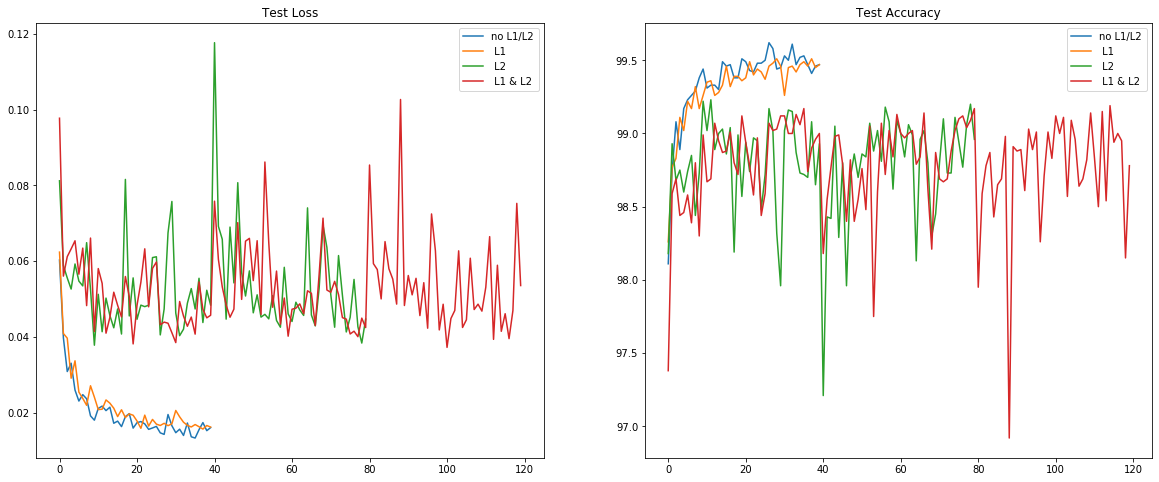

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
plotall()